An advertising promotion is tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. 

#### Optimization Strategy

Task is to use the training data to understand what patterns in 'Features' to indicate that a promotion should be provided to a user. Specifically,  goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. 

* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. 

In [1]:
# load in packages
from itertools import combinations

#from test_results import valid_results, test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from google.oauth2 import service_account #For GCP Account connection
from google.cloud import bigquery

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

#Setting Up Project ID
project_id = "dsmt-team5-finalproject"
#Setting up the credential file
cred = service_account.Credentials.from_service_account_file('dsmt-team5-finalproject-4f1119faadf9.json')
#Setting up a BigQuery Client:
client = bigquery.Client(project=project_id, credentials=cred)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
# load in the data
daily_data_sql = """SELECT * FROM `dsmt-team5-finalproject.tacobell.daily_data_rolling`"""
daily_data = client.query(daily_data_sql).to_dataframe()
daily_data.head()

,day_num,per_id,offer_id,daily_amt_spent,num_trans,amt_spent_per_trans,num_offers,cost,profit,has_profit,target,quadrant,age,became_member_on,gender,income,gender_F,gender_M,gender_O,difficulty,duration,reward,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational,offer_id_0,offer_id_1,offer_id_2,offer_id_3,offer_id_4,offer_id_5,offer_id_6,offer_id_7,offer_id_8,offer_id_9,offer_id_10
0,0.0,1.0,3.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0,2,40,20180109,O,57000.0,0,0,1,0,96,0,1,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0
1,0.0,1.0,10.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0,3,40,20180109,O,57000.0,0,0,1,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0.0,2.0,10.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0,3,59,20160304,F,90000.0,1,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0.0,4.0,10.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0,3,26,20170621,F,73000.0,1,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0.0,5.0,10.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0,3,19,20160809,F,65000.0,1,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [3]:
# check number of missing values per column
daily_data.isnull().mean()

day_num                     0.0
per_id                      0.0
offer_id                    0.0
daily_amt_spent             0.0
num_trans                   0.0
amt_spent_per_trans         0.0
num_offers                  0.0
cost                        0.0
profit                      0.0
has_profit                  0.0
target                      0.0
quadrant                    0.0
age                         0.0
became_member_on            0.0
gender                      0.0
income                      0.0
gender_F                    0.0
gender_M                    0.0
gender_O                    0.0
difficulty                  0.0
duration                    0.0
reward                      0.0
email                       0.0
mobile                      0.0
social                      0.0
web                         0.0
offer_type_bogo             0.0
offer_type_discount         0.0
offer_type_informational    0.0
offer_id_0                  0.0
offer_id_1                  0.0
offer_id

In [0]:
def generate_offer_daily_data(offer_name, daily_data, start_day=0,\
                                end_day=29):

       # Generate the subset of the original daily data that is relevant to 
       # the current offer.

    for day_num in range(start_day,end_day+1):
        # get the current day's data FOR ALL THE DAYS
        day_subset = daily_data[daily_data['day_num']==day_num]
        day_subset = day_subset[(day_subset[offer_name]==1) |\
                                    (day_subset['offer_id_10']==1)]
        
        # get individuals who received the offer DURING THE PARTICULAR 1 DAY
        day_offer_indiv =\
        day_subset[day_subset[offer_name]==1].per_id.unique()           #unique per_id who received the offer 0
        if day_num == start_day:
            new_daily_data =\
            day_subset[day_subset['per_id'].isin(day_offer_indiv)]      # new_daily_data = day_subset data that contains the per_id who received the offer on day 0
        else:
            new_day_data =\
            day_subset[day_subset['per_id'].isin(day_offer_indiv)]
            new_daily_data =\
            pd.concat([new_daily_data, new_day_data], axis=0)
    new_daily_data.reset_index(inplace=True)
    return new_daily_data

In [0]:
train_data = generate_offer_daily_data('offer_id_0', daily_data)

In [0]:
features = ['day_num', 'per_id', 'age', 'became_member_on', 'income', 'gender_F', 'gender_M','gender_O']

In [7]:
train_data['target'].value_counts()

0    12744
1     2830
Name: target, dtype: int64

In [0]:
# testing baseline model, where we send promotions to everyone

def promotion_strategy(df):
    
    test = df
    
    promotion = []
    
    num_test_points = test.shape[0]
    
    for i in range(num_test_points):
        promotion.append('Yes')
        
    promotion = np.array(promotion)
    
    return promotion

In [0]:
import pandas as pd
import numpy as np

def score(df, promo_pred_col = 'offer_id',promo_pred_col_2 = 'quadrant'):
    n_treat       = df.loc[df[promo_pred_col] != 10 ,:].shape[0]
    n_control     = df.loc[df[promo_pred_col] == 10 ,:].shape[0]
   
    n_treat_purch = df.loc[df[promo_pred_col_2] == 0 ].shape[0]
    
   
    n_ctrl_purch  = df.loc[df[promo_pred_col_2] == 1 ].shape[0]
    
    irr = n_treat_purch / n_treat - n_ctrl_purch / n_control
    nir = 10 * n_treat_purch - 0.15 * n_treat - 10 * n_ctrl_purch
    return (irr, nir)
  
    

# added this function to test our irr and nlr on the validation set
def valid_results(promotion_strategy, valid_data):
    df = valid_data[['day_num', 'per_id','age','became_member_on', 'income', 'gender_F', 'gender_M','gender_O']]
                    
    promos = promotion_strategy(df)
    score_df = valid_data.iloc[np.where(promos == 'Yes')]    
    irr, nir = score(score_df)
   
    
    print('Irr with this strategy is {:0.4f}.'.format(irr))
    print()
   
    print('Nir with this strategy is {:0.2f}.'.format(nir))
    print()
    
    return irr, nir
   
def test_results(promotion_strategy):
    test_data_sql = """SELECT * FROM `dsmt-team5-finalproject.tacobell.rr_test_case`"""
    test_data = client.query(test_data_sql).to_dataframe()
    df = test_data[['day_num', 'per_id','age','became_member_on', 'income', 'gender_F', 'gender_M','gender_O']]
    promos = promotion_strategy(df)
    score_df = test_data.iloc[np.where(promos == 'Yes')]    
    irr, nir = score(score_df)
    
    print('Irr with this strategy is {:0.4f}.'.format(irr))
    print()
    print('Nir with this strategy is {:0.2f}.'.format(nir))
    
    
    return irr, nir

In [0]:
# This will test the baseline strategy

#test_results(promotion_strategy)

If we were to send everyone a promotion, this will be the baseline model. Hence, sending everyone a promotion is going to lose the company a lot of money.

## Model 1: Predict only for individuals who received promotions and purchased

In this approach, we will assign labels of 1 to those who received the promotions and made purchases, and labels of 0 to everyone else. In other words, we want the model to find the individuals who are likely to purchase only after they received a promotion. 

In [13]:
train_data.head()

,index,day_num,per_id,offer_id,daily_amt_spent,num_trans,amt_spent_per_trans,num_offers,cost,profit,has_profit,target,quadrant,age,became_member_on,gender,income,gender_F,gender_M,gender_O,difficulty,duration,reward,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational,offer_id_0,offer_id_1,offer_id_2,offer_id_3,offer_id_4,offer_id_5,offer_id_6,offer_id_7,offer_id_8,offer_id_9,offer_id_10
0,112,0.0,93.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0,2,49,20170126,M,73000.0,0,1,0,20,240,5,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0
1,113,0.0,93.0,10.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0,3,49,20170126,M,73000.0,0,1,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,114,0.0,94.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0,2,44,20180312,F,76000.0,1,0,0,20,240,5,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0
3,115,0.0,94.0,10.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0,3,44,20180312,F,76000.0,1,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,166,0.0,134.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0,2,62,20180629,F,40000.0,1,0,0,20,240,5,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0


In [0]:
# split data into train and valid
train, valid = sk.model_selection.train_test_split(train_data, test_size=0.2,random_state=42)

In [15]:
# This will test your results, for baseline strategy
# test irr and nlr on our validation set
valid_results(promotion_strategy, valid)

Irr with this strategy is 0.2300.

Nir with this strategy is 3249.60.



(0.230019741529449, 3249.6000000000004)

In [0]:
# generate features and labels
Y_train = train['target']
X_train = train[features]

Y_valid = valid['target']
X_valid = valid[features]

In [17]:
Y_train.value_counts()

0    10172
1     2287
Name: target, dtype: int64

In [0]:
# up sample only the train dataset with SMOTE
sm = SMOTE(random_state=42, ratio = 1.0)
X_train_upsamp, Y_train_upsamp = sm.fit_sample(X_train, Y_train)
    
X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=features)

Y_train_upsamp = pd.Series(Y_train_upsamp)

In [19]:
#Train an xgboost model
eval_set = [(X_train_upsamp, Y_train_upsamp), (X_valid, Y_valid)]
model = xgb.XGBClassifier(learning_rate = 0.1,\
                          max_depth = 7,\
                          min_child_weight = 5,\
                          objective = 'binary:logistic',\
                          seed = 42,\
                          gamma = 0.1,\
                          silent = True)
model.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set,\
          eval_metric="auc", verbose=True, early_stopping_rounds=30)

#import pickle
# save model to file
#pickle.dump(model, open("uplift.pickle.dat", "wb"))

[0]	validation_0-auc:0.843711	validation_1-auc:0.719193
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.844779	validation_1-auc:0.730671
[2]	validation_0-auc:0.932221	validation_1-auc:0.791583
[3]	validation_0-auc:0.925724	validation_1-auc:0.789821
[4]	validation_0-auc:0.93245	validation_1-auc:0.792745
[5]	validation_0-auc:0.939509	validation_1-auc:0.793682
[6]	validation_0-auc:0.937903	validation_1-auc:0.791756
[7]	validation_0-auc:0.943157	validation_1-auc:0.794192
[8]	validation_0-auc:0.941479	validation_1-auc:0.792058
[9]	validation_0-auc:0.941395	validation_1-auc:0.792035
[10]	validation_0-auc:0.945044	validation_1-auc:0.793527
[11]	validation_0-auc:0.948979	validation_1-auc:0.794559
[12]	validation_0-auc:0.947957	validation_1-auc:0.793674
[13]	validation_0-auc:0.950512	validation_1-auc:0.794982
[14]	validation_0-auc:0.948909	validation_1-auc:0.79382


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=True, subsample=1, verbosity=1)

In [0]:
# load model from file
#loaded_model = pickle.load(open("uplift.pickle.dat", "rb"))

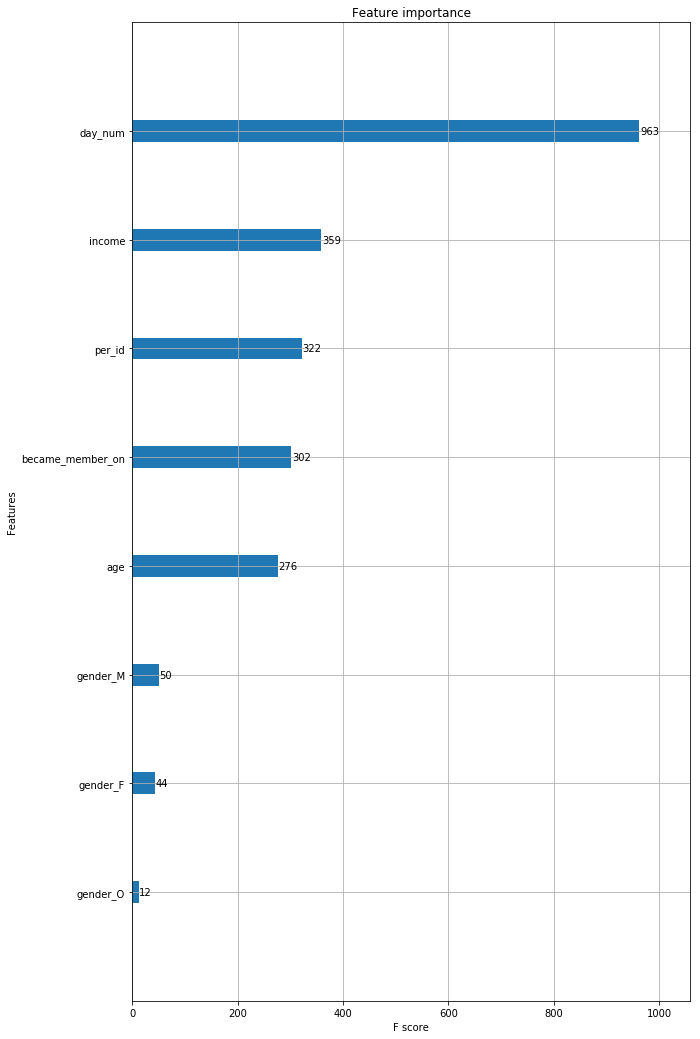

In [21]:
# check which features are important

from xgboost import plot_importance
from matplotlib import pyplot

fig, ax = pyplot.subplots(figsize=(10, 18));
xgb.plot_importance(model, ax=ax);

In [22]:
# confusion matrix
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix
cm(Y_valid, valid_pred)

array([[2147,  425],
       [ 156,  387]])

In [0]:
def promotion_strategy(df):

    test = df
    
    preds = model.predict(test, ntree_limit=model.best_ntree_limit)

    promotion = []
    for pred in preds:
        if pred == 1:
            promotion.append('Yes')
        else:
            promotion.append('No')
    promotion = np.array(promotion)
    return promotion

In [24]:
# test irr and nlr on our validation set
valid_results(promotion_strategy, valid)

Irr with this strategy is 0.9200.

Nir with this strategy is 3471.95.



(0.92, 3471.95)

In [0]:
# This will test results, and provide back how well your promotion_strategy will work in practice

#test_results(promotion_strategy)

## Model 2: Using Two Models

In this approach, we will train two models. 
One model will be trained on the treatment group (those who received the promotion) and we will refer to this model as the treatment model. 
Another model will be trained on the control group (those who did not received the promotion), and we will refer to this as the control model. 
The target of both models will be whether the individual made the purchase or not. 
The treatment model will predict the probability that individual will make a purchase if he or she received the promotion, while the control model will predict the probability that individual will make a purchase if he or she did not receive the promotion. 
Ideally the difference in the probabilities, which we will call the lift will tell us the probability that sending a promotion to an individual will increase his or her willingness to make a purhcase vs not sending a promotion. We can then send promotions to individuals with lift values higher than a pre-defined cutoff percentile. For example, we can send promotions to individuals in the top 3 deciles.

In [0]:
# split data into train and valid
train, valid = sk.model_selection.train_test_split(train_data, test_size=0.2,random_state=42)

In [0]:
features = ['day_num', 'per_id', 'age', 'became_member_on', 'income', 'gender_F', 'gender_M','gender_O']

# Generate validation data one for control group, another for treatment group
valid_control = valid[valid['offer_id']==10]
Y_valid_control = valid_control['has_profit']
X_valid_control = valid_control[features]

valid_exper = valid[valid['offer_id']!=10]
Y_valid_exper = valid_exper['has_profit']
X_valid_exper = valid_exper[features]

In [0]:
# generate training data
train_control = train[train['offer_id']==10]
Y_train_control = train_control['has_profit']
X_train_control = train_control[features]

train_exper = train[train['offer_id']!=10]
Y_train_exper = train_exper['has_profit']
X_train_exper = train_exper[features]

In [0]:
# up-sample training data with SMOTE
sm = SMOTE(random_state=42, ratio = 1.0)

# up-sample control group
X_train_control_upsamp, Y_train_control_upsamp = sm.fit_sample(X_train_control, Y_train_control)
X_train_control_upsamp = pd.DataFrame(X_train_control_upsamp, columns=features)
Y_train_control_upsamp = pd.Series(Y_train_control_upsamp)

# up-sample treatment group
X_train_exper_upsamp, Y_train_exper_upsamp = sm.fit_sample(X_train_exper, Y_train_exper)    
X_train_exper_upsamp = pd.DataFrame(X_train_exper_upsamp, columns=features)
Y_train_exper_upsamp = pd.Series(Y_train_exper_upsamp)

In [32]:
# train control model
eval_set = [(X_train_control_upsamp, Y_train_control_upsamp), (X_valid_control, Y_valid_control)]
model_control = xgb.XGBClassifier(learning_rate = 0.1,\
                                  max_depth = 7,\
                                  min_child_weight = 5,\
                                  objective = 'binary:logistic',\
                                  seed = 42,\
                                  gamma = 1,\
                                  #colsample_bytree = 0.1,\
                                  silent = True)
model_control.fit(X_train_control_upsamp, Y_train_control_upsamp, eval_set=eval_set,\
                    eval_metric="auc", verbose=True, early_stopping_rounds=30)

[0]	validation_0-auc:0.861602	validation_1-auc:0.534095
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.885753	validation_1-auc:0.534178
[2]	validation_0-auc:0.887618	validation_1-auc:0.539351
[3]	validation_0-auc:0.89351	validation_1-auc:0.543364
[4]	validation_0-auc:0.89371	validation_1-auc:0.545431
[5]	validation_0-auc:0.904315	validation_1-auc:0.539903
[6]	validation_0-auc:0.908736	validation_1-auc:0.542078
[7]	validation_0-auc:0.911288	validation_1-auc:0.539438
[8]	validation_0-auc:0.915773	validation_1-auc:0.537326
[9]	validation_0-auc:0.916858	validation_1-auc:0.536157
[10]	validation_0-auc:0.918738	validation_1-auc:0.533743
[11]	validation_0-auc:0.924546	validation_1-auc:0.532779
[12]	validation_0-auc:0.927831	validation_1-auc:0.532713
[13]	validation_0-auc:0.928186	validation_1-auc:0.53589
[14]	validation_0-auc:0.930783	validation_1-auc:0.536387
[

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=True, subsample=1, verbosity=1)

In [33]:
# train treatment model
eval_set = [(X_train_exper_upsamp, Y_train_exper_upsamp), (X_valid_exper, Y_valid_exper)]
model_exper = xgb.XGBClassifier(learning_rate = 0.1,\
                                max_depth = 7,\
                                min_child_weight = 5,\
                                objective = 'binary:logistic',\
                                seed = 42,\
                                gamma = 1,\
                                #colsample_bytree = 0.1,\
                                silent = True)
model_exper.fit(X_train_exper_upsamp, Y_train_exper_upsamp, eval_set=eval_set,\
                eval_metric="auc", verbose=True, early_stopping_rounds=30)

[0]	validation_0-auc:0.860512	validation_1-auc:0.822347
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.942944	validation_1-auc:0.884253
[2]	validation_0-auc:0.946975	validation_1-auc:0.887605
[3]	validation_0-auc:0.944969	validation_1-auc:0.885654
[4]	validation_0-auc:0.948912	validation_1-auc:0.886489
[5]	validation_0-auc:0.948923	validation_1-auc:0.888753
[6]	validation_0-auc:0.949647	validation_1-auc:0.888214
[7]	validation_0-auc:0.950388	validation_1-auc:0.890281
[8]	validation_0-auc:0.952809	validation_1-auc:0.88892
[9]	validation_0-auc:0.953169	validation_1-auc:0.889753
[10]	validation_0-auc:0.955901	validation_1-auc:0.892462
[11]	validation_0-auc:0.956347	validation_1-auc:0.893301
[12]	validation_0-auc:0.957941	validation_1-auc:0.893658
[13]	validation_0-auc:0.958667	validation_1-auc:0.893347
[14]	validation_0-auc:0.958474	validation_1-auc:0.89253


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=True, subsample=1, verbosity=1)

In [0]:
# make predictions on the validation data sets for both models
control_valid_pred = model_control.predict(X_valid_control, ntree_limit=model_control.best_ntree_limit)
exper_valid_pred = model_exper.predict(X_valid_exper, ntree_limit=model_exper.best_ntree_limit)

In [35]:
# confusion marix for thge validation set
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix(Y_valid_exper, exper_valid_pred)

cm

array([[992,   1],
       [140, 403]])

In [0]:
def promotion_strategy(df):

    test = df
    
    pred_probs_contol = model_control.predict_proba(test, ntree_limit=model_control.best_ntree_limit)

    pred_probs_exper = model_exper.predict_proba(test, ntree_limit=model_exper.best_ntree_limit)

    # get difference in probabilities between experimental and cpntrol model for purchase = 1 label
    lift = pred_probs_exper[:,1] - pred_probs_contol[:,1]
    
    promotion = []
    
    # Only send promotions to top 3 percentile of probabilities
    cutoff_lift = np.percentile(lift, 97)
    
    for prob in lift:
        if prob > 0:
            if prob > cutoff_lift:
                promotion.append('Yes')
        else:
            promotion.append('No')

    promotion = np.array(promotion)
    
    return promotion

In [37]:
# find out irr and nlr on our validation set
valid_results(promotion_strategy, valid)

Irr with this strategy is 0.3821.

Nir with this strategy is 182.65.



(0.3820598006644518, 182.65)

In [0]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

#test_results(promotion_strategy)

## Model 3: Using Treatment Dummy Approach

In this approach, a single model is used to model the data. This approach adds an additional indicator variable to track if an individual is in a treatment or control group during training. Any individuals who made purchases will be given a label of 1, irregradless of whether he or she is in the control or treatment group. 

To predict whether a new individual in a test set is likely to make a purhcase only after receiving a promotion, we can first calculate the probability that the individual will make a purchase if he or she is in the treatment group by setting the treatment indicator as 1. Next, we calculate the probability that the individual will make a purchase if he or she is in the control group by setting the treatment indicator as 0. The difference in the two probabilities will be the lift value, aka, how positively influenced the individual is as a result of the treatment (receiving promotion)

We can opt to send promotions to individuals with prostive lift values. 

In [39]:
# encode Promotion as 0 or 1 indicator variable
train_data['treatment'] = np.where(train_data['offer_id'] != 10, 1, 0)
train_data.head()

,index,day_num,per_id,offer_id,daily_amt_spent,num_trans,amt_spent_per_trans,num_offers,cost,profit,has_profit,target,quadrant,age,became_member_on,gender,income,gender_F,gender_M,gender_O,difficulty,duration,reward,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational,offer_id_0,offer_id_1,offer_id_2,offer_id_3,offer_id_4,offer_id_5,offer_id_6,offer_id_7,offer_id_8,offer_id_9,offer_id_10,treatment
0,112,0.0,93.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0,2,49,20170126,M,73000.0,0,1,0,20,240,5,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
1,113,0.0,93.0,10.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0,3,49,20170126,M,73000.0,0,1,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,114,0.0,94.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0,2,44,20180312,F,76000.0,1,0,0,20,240,5,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
3,115,0.0,94.0,10.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0,3,44,20180312,F,76000.0,1,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,166,0.0,134.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0,2,62,20180629,F,40000.0,1,0,0,20,240,5,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1


In [0]:
train, valid = sk.model_selection.train_test_split(train_data, test_size=0.2,random_state=42)

features = ['day_num', 'per_id', 'age', 'became_member_on', 'income', 'gender_F', 'gender_M','gender_O','treatment']

Y_train = train['has_profit']
X_train = train[features]

Y_valid = valid['has_profit']
X_valid = valid[features]

In [0]:
# up sample with SMOTE
sm = SMOTE(random_state=42, ratio = 1.0)
X_train_upsamp, Y_train_upsamp = sm.fit_sample(X_train, Y_train)
    
X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=features)

Y_train_upsamp = pd.Series(Y_train_upsamp)

In [42]:
eval_set = [(X_train_upsamp, Y_train_upsamp), (X_valid, Y_valid)]
model = xgb.XGBClassifier(learning_rate = 0.1,\
                                  max_depth = 7,\
                                  min_child_weight = 5,\
                                  objective = 'binary:logistic',\
                                  seed = 42,\
                                  gamma = 0.1,\
                                  silent = True)
model.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set,\
                    eval_metric="auc", verbose=True, early_stopping_rounds=30)

[0]	validation_0-auc:0.890381	validation_1-auc:0.766088
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.90868	validation_1-auc:0.783147
[2]	validation_0-auc:0.910981	validation_1-auc:0.783784
[3]	validation_0-auc:0.910802	validation_1-auc:0.783867
[4]	validation_0-auc:0.930741	validation_1-auc:0.800555
[5]	validation_0-auc:0.931316	validation_1-auc:0.800174
[6]	validation_0-auc:0.931643	validation_1-auc:0.800364
[7]	validation_0-auc:0.937656	validation_1-auc:0.804337
[8]	validation_0-auc:0.937943	validation_1-auc:0.805361
[9]	validation_0-auc:0.939328	validation_1-auc:0.803705
[10]	validation_0-auc:0.939927	validation_1-auc:0.80423
[11]	validation_0-auc:0.941199	validation_1-auc:0.804503
[12]	validation_0-auc:0.942797	validation_1-auc:0.805473
[13]	validation_0-auc:0.943537	validation_1-auc:0.803649
[14]	validation_0-auc:0.945687	validation_1-auc:0.804495


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=True, subsample=1, verbosity=1)

In [43]:
# confusion marix for thge validation set
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix(Y_valid, valid_pred)

cm

array([[2370,    7],
       [ 337,  401]])

In [0]:
def promotion_strategy(df):

    test = df
    
    # Fit a model with treatment = 1 for all data points
    test['treatment'] = 1.0
    preds_treat = model.predict_proba(test, ntree_limit=model.best_ntree_limit)
    
    # Fit a model with treatment = 0 for all data points
    test['treatment'] = 0.0
    preds_cont = model.predict_proba(test, ntree_limit=model.best_ntree_limit)
    
    lift = preds_treat[:,1] - preds_cont[:,1]
    
    promotion = []
    
    for prob in lift:
        if prob > 0:
            promotion.append('Yes')
        else:
            promotion.append('No')

    promotion = np.array(promotion)
    
    return promotion

In [45]:
# find out irr and nlr on our validation set
valid_results(promotion_strategy, valid)

Irr with this strategy is 0.3569.

Nir with this strategy is 3696.50.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


(0.3568782699399604, 3696.5)

In [0]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

#test_results(promotion_strategy)

## Model 4: Four Quadrant Method

 It suggested designing a model to predict an individual's probability of being in any of the 4 groups: TR, CR, TN, CN.

TR: Treatment and Responded. Basically received promotion and made a purchase
CR: Control and Responded. Did not receive a promotion but made a purchase
TN: Treatment and No Response. Received promotion but made no purchase
CN: Control and No Response. Did not receive a promotion and made no purchase

If an individual's TR probability is the highest among the four groups, it is likely that we will benefit by sending the individual a promotion to induce him or her to make a purchase.

In [47]:
target = []
for index, row in train_data.iterrows():
    if (row['offer_id'] != 10) & (row['has_profit'] == 1):
        # TR group
        target.append(0)
    elif (['offer_id'] == 10) & (row['has_profit'] == 1):
        # CR group
        target.append(1)
    elif (row['offer_id'] != 10) & (row['has_profit'] == 0):
        # TN group
        target.append(2)
    else: #CN group
        target.append(3)

train_data['target'] = target
train_data.head()

,index,day_num,per_id,offer_id,daily_amt_spent,num_trans,amt_spent_per_trans,num_offers,cost,profit,has_profit,target,quadrant,age,became_member_on,gender,income,gender_F,gender_M,gender_O,difficulty,duration,reward,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational,offer_id_0,offer_id_1,offer_id_2,offer_id_3,offer_id_4,offer_id_5,offer_id_6,offer_id_7,offer_id_8,offer_id_9,offer_id_10,treatment
0,112,0.0,93.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,2,2,49,20170126,M,73000.0,0,1,0,20,240,5,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
1,113,0.0,93.0,10.0,0.0,0.0,0.0,1,0.0,0.0,0.0,3,3,49,20170126,M,73000.0,0,1,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,114,0.0,94.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,2,2,44,20180312,F,76000.0,1,0,0,20,240,5,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
3,115,0.0,94.0,10.0,0.0,0.0,0.0,1,0.0,0.0,0.0,3,3,44,20180312,F,76000.0,1,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,166,0.0,134.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,2,2,62,20180629,F,40000.0,1,0,0,20,240,5,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1


In [48]:
train, valid = sk.model_selection.train_test_split(train_data, test_size=0.2,random_state=42)

abc = train_data['target']

abc.value_counts()

3    7745
2    4999
0    2830
Name: target, dtype: int64

In [0]:
#features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7']
features = ['day_num', 'per_id', 'age', 'became_member_on', 'income', 'gender_F', 'gender_M','gender_O']

Y_train = train['target']
X_train = train[features]

Y_valid = valid['target']
X_valid = valid[features]

In [50]:
Y_train.value_counts()

3    6166
2    4006
0    2287
Name: target, dtype: int64

In [51]:
# up sample with SMOTE
sm = SMOTE({0:33444, 2:33444, 3:33444}, random_state=42)
X_train_upsamp, Y_train_upsamp = sm.fit_sample(X_train, Y_train)
    
X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=features)

Y_train_upsamp = pd.Series(Y_train_upsamp)
Y_train_upsamp.value_counts()

/usr/local/lib/python3.6/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (33444) in class 0 will be larger than the number of samples in the majority class (class #3 -> 6166)
  n_samples_majority))
/usr/local/lib/python3.6/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (33444) in class 2 will be larger than the number of samples in the majority class (class #3 -> 6166)
  n_samples_majority))
/usr/local/lib/python3.6/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (33444) in class 3 will be larger than the number of samples in the majority class (class #3 -> 6166)
  n_samples_majority))


3    33444
2    33444
0    33444
dtype: int64

In [52]:
X_train_upsamp.head()

,day_num,per_id,age,became_member_on,income,gender_F,gender_M,gender_O
0,10.0,13922.0,65.0,20171226.0,63000.0,1.0,0.0,0.0
1,13.0,10004.0,50.0,20150824.0,84000.0,1.0,0.0,0.0
2,17.0,1509.0,60.0,20160215.0,100000.0,1.0,0.0,0.0
3,17.0,9394.0,57.0,20150927.0,87000.0,1.0,0.0,0.0
4,21.0,14069.0,50.0,20160715.0,53000.0,1.0,0.0,0.0


In [53]:
eval_set = [(X_train_upsamp, Y_train_upsamp), (X_valid, Y_valid)]
model = xgb.XGBClassifier(learning_rate = 0.1,\
                          num_class=4,\
                                  max_depth = 7,\
                                  min_child_weight = 5,\
                                  objective = 'multi:softmax',\
                                  seed = 42,\
                                  gamma = 0.1,\
                                  silent = True)
model.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set,\
                    eval_metric="mlogloss", verbose=True, early_stopping_rounds=30)

[0]	validation_0-mlogloss:1.08849	validation_1-mlogloss:1.09031
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 30 rounds.
[1]	validation_0-mlogloss:1.07938	validation_1-mlogloss:1.0828
[2]	validation_0-mlogloss:1.07186	validation_1-mlogloss:1.07573
[3]	validation_0-mlogloss:1.0651	validation_1-mlogloss:1.07004
[4]	validation_0-mlogloss:1.0595	validation_1-mlogloss:1.06499
[5]	validation_0-mlogloss:1.0539	validation_1-mlogloss:1.06134
[6]	validation_0-mlogloss:1.04927	validation_1-mlogloss:1.05778
[7]	validation_0-mlogloss:1.04467	validation_1-mlogloss:1.05436
[8]	validation_0-mlogloss:1.04076	validation_1-mlogloss:1.05151
[9]	validation_0-mlogloss:1.03715	validation_1-mlogloss:1.04923
[10]	validation_0-mlogloss:1.03352	validation_1-mlogloss:1.04483
[11]	validation_0-mlogloss:1.03007	validation_1-mlogloss:1.04291
[12]	validation_0-mlogloss:1.02683	validation_1-mlogloss:1.04007
[1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.1,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, num_class=4, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=42, silent=True, subsample=1, verbosity=1)

In [54]:
# confusion marix for thge validation set
# Note:
# TR: treatment and respond group (received promotion and made purchase)
# CR: control and respond group (did not receive promotion but made purchase)
# TN: treatment and no respond group (received promotion but did not made purchase)
# CR: control and no respond group (did not receive promotion and made no purchase)
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix(Y_valid, valid_pred)

cm

array([[241,  86, 216],
       [  2, 539, 452],
       [324, 882, 373]])

In [0]:
def promotion_strategy(df):

    test = df
    
    pred = model.predict(test, ntree_limit=model.best_ntree_limit)
    
    promotion = []
    
    for pred in pred:
        if pred == 0:
            promotion.append('Yes')
        else:
            promotion.append('No')
    
    promotion = np.array(promotion)
    
    return promotion

In [56]:
# find out irr and nlr on our validation set
valid_results(promotion_strategy, valid)

Irr with this strategy is 0.9146.

Nir with this strategy is 2123.55.



(0.9146090534979424, 2123.55)

In [0]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

#test_results(promotion_strategy)

Thus, model 3 gives the best strategy and will be used for evaluating our individual offers to predict the best irr and nir for the Test_case customers

This approach is first suggested by Victor Lo in the [presentation](https://www.slideshare.net/odsc/victor-lomachinelearningpresentation).